In [1]:
# The MIT License (MIT)

# Copyright (c) 2020, NVIDIA CORPORATION.

# Permission is hereby granted, free of charge, to any person obtaining a copy of
# this software and associated documentation files (the "Software"), to deal in
# the Software without restriction, including without limitation the rights to
# use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of
# the Software, and to permit persons to whom the Software is furnished to do so,
# subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS
# FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
# COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER
# IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN
# CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE

# Tutorial: Feature Engineering for Recommender Systems

# Infrastructure

In our tutorial, we are using [RAPIDS.AI cudf](https://github.com/rapidsai/cudf), an GPU accelerated dataframe. The API is similar to pandas, but the calculations are executed on the GPU.

In [1]:
import cudf

We are using a NVIDIA Tesla T4 GPU with 16 GB memory.

In [2]:
!nvidia-smi

Mon Sep 21 13:27:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    27W /  70W |     11MiB / 15109MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# 1. Exploring Dataset

In our tutorial, we want to explain and show the value of preprocessing and feature engineering on a real-world dataset. Therefore, we use the [eCommerce behavior data from multi category store](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) from [REES46 Marketing Platform](https://rees46.com/) as our dataset. In a few cases, we will use synthetic data to show the calculations in order to explain the theory.<br><br>

[eCommerce behavior data from multi category store](https://www.kaggle.com/mkechinov/ecommerce-behavior-data-from-multi-category-store) is a dataset containing the user behavior (view/add to cart/ purchase) of an ecommerce shop over 7 months.
* Events: View, AddToCart, Purchase
* Timeframe: Oct-2019 - April 2020
<br><br>
As the dataset contains only interactions (positive samples), we need to define a goal / target to predict. There is a lot of literature about how to construct negative samples from the dataset in order to make the goal easier or harder to predict.<br><br>
For our tutorial, we decided that our goal is to predict if a user purchased an item:

<li> Positive: User purchased an item
<li> Negative: User added an item to the cart, but did not purchase it (in the same session)    
<br><br>    
We split the dataset in train, validation and testset by the timestamp:
<li> Training: October 2019 - February 2020
<li> Validation: March 2020
<li> Test: April 2020

Let's have a short look on the dataset

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
import IPython

import cudf
import pandas as pd
import matplotlib.pyplot as plt

In [5]:
df_train = pd.read_parquet('../data/train.parquet')
df_valid = pd.read_parquet('../data/valid.parquet')
df_test = pd.read_parquet('../data/test.parquet')

In [6]:
df_train.shape, df_valid.shape, df_test.shape

((11461357, 19), (2461719, 19), (2772486, 19))

In [7]:
df = pd.concat([df_train, df_valid, df_test],ignore_index=True)

In [8]:
df.shape

(16695562, 19)

In [9]:
df['timestamp'] = pd.to_datetime(df['timestamp'])

In [10]:
df.head()

,event_time,event_type,product_id,brand,price,user_id,user_session,target,cat_0,cat_1,cat_2,cat_3,timestamp,ts_hour,ts_minute,ts_weekday,ts_day,ts_month,ts_year
0,2019-12-01 00:00:28 UTC,cart,17800342,zeta,66.90,550465671,22650a62-2d9c-4151-9f41-2674ec6d32d5,0,computers,desktop,None,None,2019-12-01 00:00:28,0,0,6,1,12,2019
1,2019-12-01 00:00:39 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,None,2019-12-01 00:00:39,0,0,6,1,12,2019
2,2019-12-01 00:00:40 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,None,2019-12-01 00:00:40,0,0,6,1,12,2019
3,2019-12-01 00:00:41 UTC,cart,3701309,polaris,89.32,543733099,a65116f4-ac53-4a41-ad68-6606788e674c,0,appliances,environment,vacuum,None,2019-12-01 00:00:41,0,0,6,1,12,2019
4,2019-12-01 00:01:56 UTC,cart,1004767,samsung,235.60,579970209,c6946211-ce70-4228-95ce-fd7fccdde63c,0,construction,tools,light,None,2019-12-01 00:01:56,0,1,6,1,12,2019


We have the following features:
* timestamp
* user_id
* user_session
* product_id
* brand
* price
* category level 0-4
* time features: hour, minute, weekday, day, month, year

In [11]:
df.target.mean()

0.37005540753884175

In [12]:
df['event_type'].value_counts(normalize=True)

cart        0.629945
purchase    0.370055
Name: event_type, dtype: float64

Around 37.0% of datapoints are purchases. Lets take a look on the sparsity of the data.

In [13]:
print('# of datapoints:' + str(df.shape))
print('# of unique users:' + str(df['user_id'].drop_duplicates().shape))
print('# of unique products:' + str(df['product_id'].drop_duplicates().shape))
print('# of unique sessions:' + str(df['user_session'].drop_duplicates().shape))

# of datapoints:(16695562, 19)
# of unique users:(3584800,)
# of unique products:(214907,)
# of unique sessions:(10715053,)


In the beginning, we should do some Exploratory Data Analysis (EDA) to get some understanding and feeling for the data.

In [14]:
def plot_sparse(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats_sort = stats['count'].value_counts().reset_index()
    stats_sort = stats_sort.sort_values('index')
    plt.figure(figsize=(15,4))
    plt.bar(stats_sort['index'].astype(str).values[0:20], stats_sort['count'].values[0:20])
    plt.title('Frequency of ' + str(col))
    plt.xlabel('Number frequency')
    plt.ylabel('Frequency')

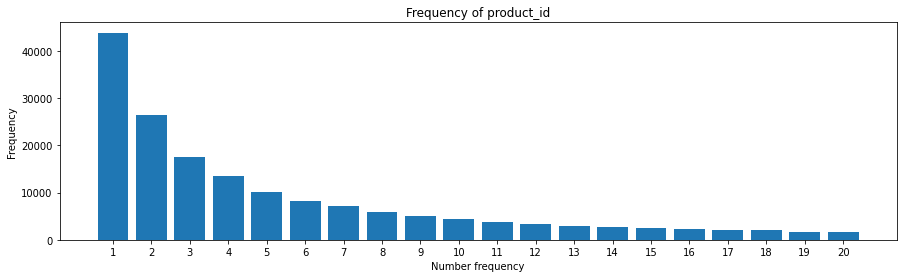

In [15]:
plot_sparse(df, 'product_id')

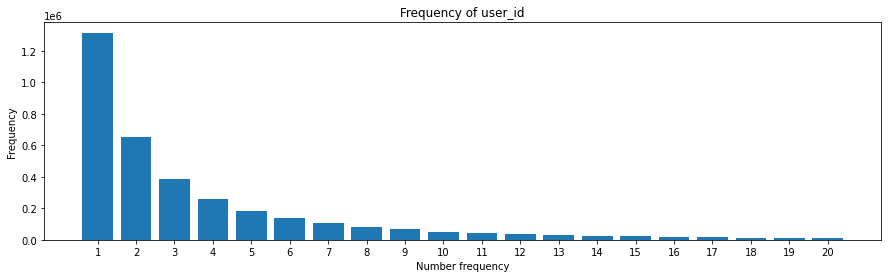

In [16]:
plot_sparse(df, 'user_id')

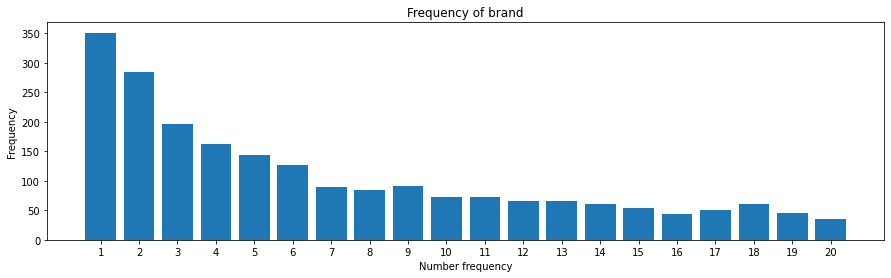

In [17]:
plot_sparse(df, 'brand')

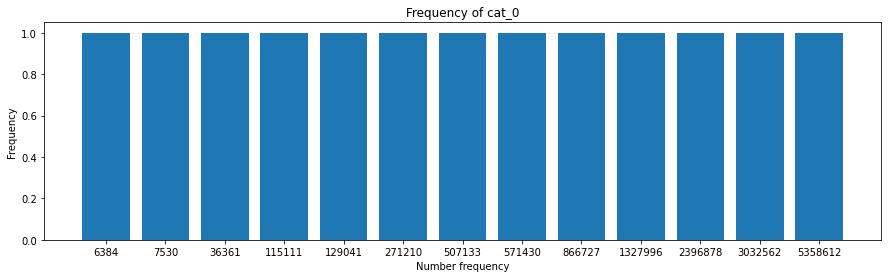

In [18]:
plot_sparse(df, 'cat_0')

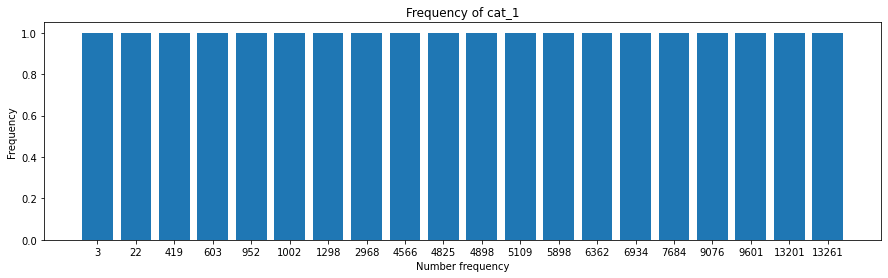

In [19]:
plot_sparse(df, 'cat_1')

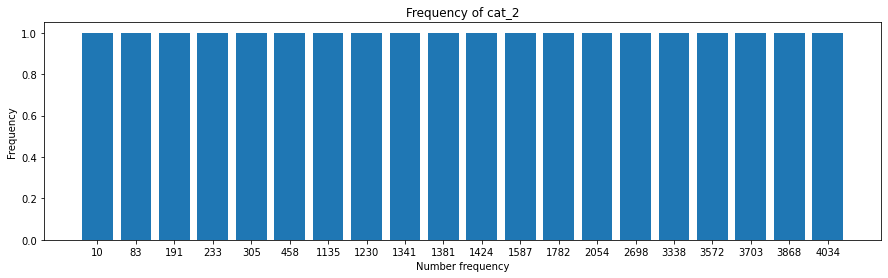

In [20]:
plot_sparse(df, 'cat_2')

We can observe following pattern:
<li> There are ~45000 products which appear only once in the dataset
<li> There are 1200000 users which appear only once in the dataset
<li> There are 350 brands which appears only once in the dataset
<li> There are 0 cat0, 0 cat1 and 0 cat2 which appear only once in the dataset<br>
    
The sparsity is important for understanding which features can be better used in a model. Product_id and User_id have many values which appear only once and the model is less able to learn a good patterns from them.<br>
On the other hand, brands, cat1, cat2 and cat3 have many observations and can be leveraged for prediction.

In [21]:
def plot_top20(df, col):
    stats = df[[col, 'target']].groupby(col).agg(['count', 'mean', 'sum'])
    stats = stats.reset_index()
    stats.columns = [col, 'count', 'mean', 'sum']
    stats = stats.sort_values('count', ascending=False)
    fig, ax1 = plt.subplots(figsize=(15,4))
    ax2 = ax1.twinx()
    ax1.bar(stats[col].astype(str).values[0:20], stats['count'].values[0:20])
    ax1.set_xticklabels(stats[col].astype(str).values[0:20], rotation='vertical')
    ax2.plot(stats['mean'].values[0:20], color='red')
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Mean Target')
    ax1.set_ylabel('Frequency')
    ax1.set_xlabel(col)
    ax1.set_title('Top20 ' + col + 's based on frequency')

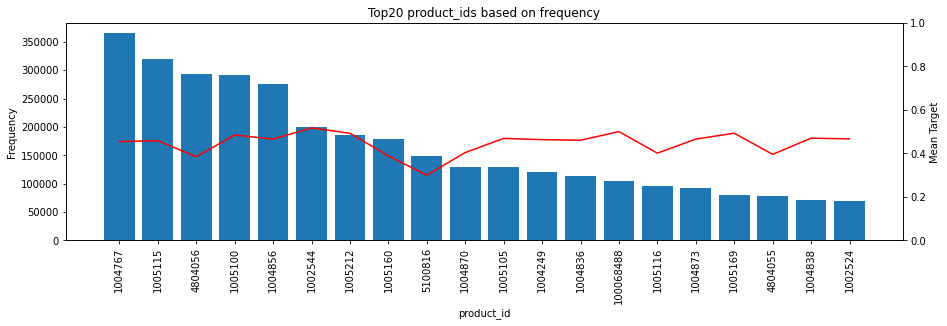

In [22]:
plot_top20(df, 'product_id')

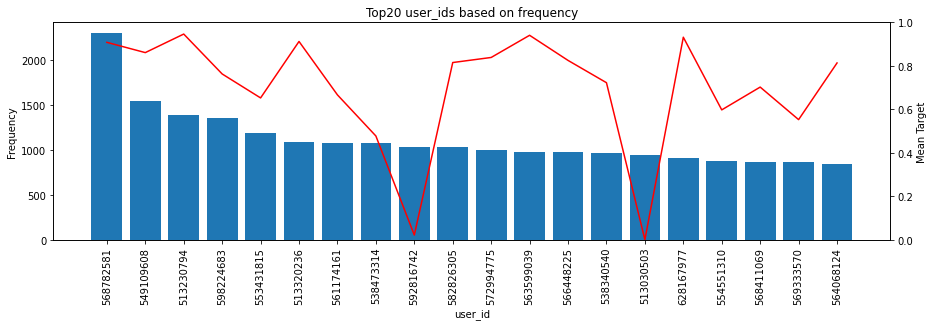

In [23]:
plot_top20(df, 'user_id')

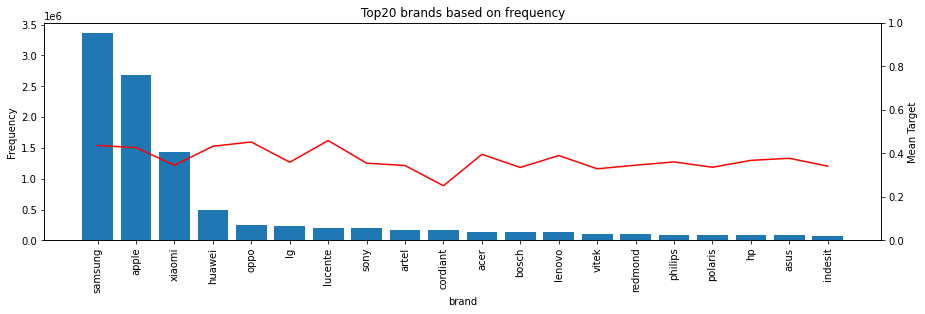

In [24]:
plot_top20(df, 'brand')

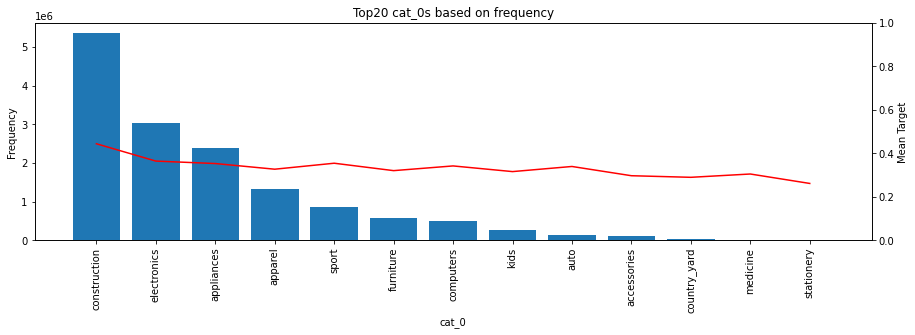

In [25]:
plot_top20(df, 'cat_0')

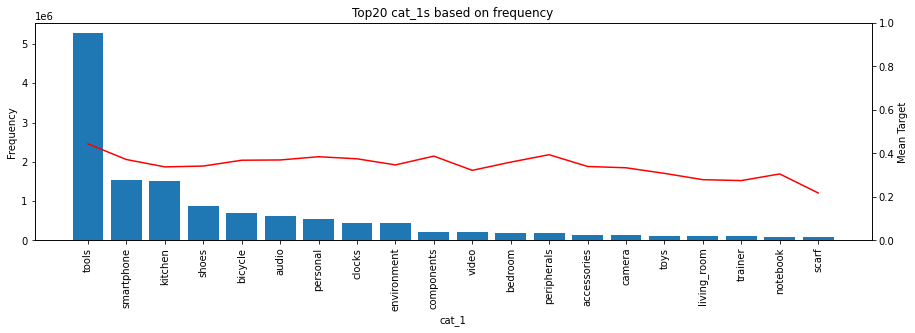

In [26]:
plot_top20(df, 'cat_1')

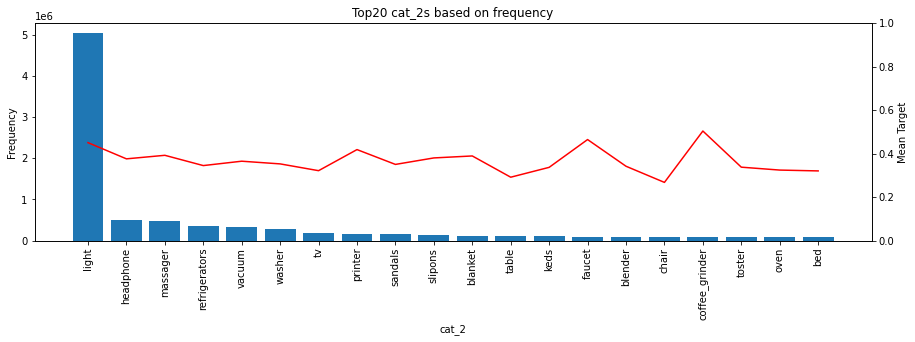

In [27]:
plot_top20(df, 'cat_2')

We can see for the different categorical features, that the top values have many observations and some variance in the target. That is good to train models on top of these features.<br><br>
Finally, we can take a look on the target over time.

In [28]:
df['date'] = pd.to_datetime(df['timestamp']).dt.date

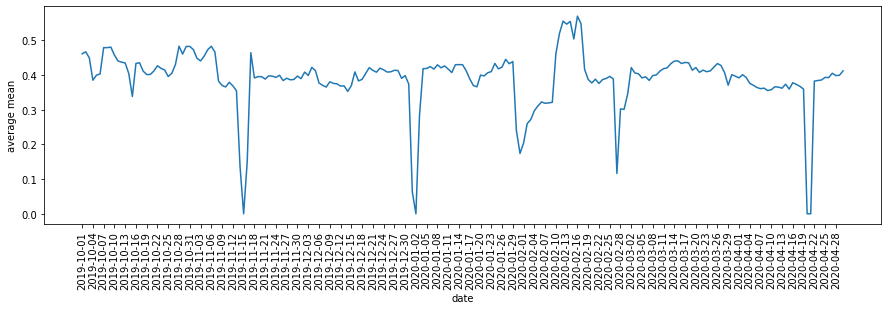

In [29]:
plt.figure(figsize=(15,4))
plt.plot(df[['date', 'target']].groupby('date').target.mean())
plt.ylabel('average mean')
plt.xlabel('date')
plt.xticks(df[['date', 'target']].groupby('date').target.mean().index[::3], rotation='vertical')
print('')

In [30]:
df[['date', 'target']].groupby('date').target.mean().sort_values().head(20)

date
2020-01-02    0.000000
2019-11-15    0.000000
2020-04-20    0.000105
2020-04-21    0.000155
2020-01-01    0.063080
2020-02-27    0.116180
2019-11-14    0.136121
2019-11-16    0.150579
2020-01-31    0.173862
2020-02-01    0.203927
2020-01-30    0.239515
2020-02-02    0.259636
2020-02-03    0.271740
2020-01-03    0.283342
2020-02-04    0.297116
2020-02-29    0.300999
2020-02-28    0.302230
2020-02-05    0.310806
2020-02-07    0.318525
2020-02-08    0.319560
Name: target, dtype: float64

## Summary:
<li> We explored the data and saw the different raw features available in the dataset.
<li> We analzyed basic statistics of the raw features and saw long-tail distribution for categorical features (user, item, brand)
<li> Some categorical features (categories) have high occurances
<li> In general, we see that categorical features have variance in the target, which we can leverage to engineer more powerful features

We shutdown the kernel.

In [31]:
app = IPython.Application.instance()
app.kernel.do_shutdown(False)

{'status': 'ok', 'restart': False}